# Introduction to cluster expansions

This notebook provides a very short introduction to cluster expansions using the [`icet` package](https://icet.materialsmodeling.org).

In [1]:
import numpy as np

We consider a simple face-centered cubic lattice.
We fetch the primitive structure from an [ase database](https://wiki.fysik.dtu.dk/ase/ase/db/db.html) of prototype structures.
The [`ClusterSpace` object](https://icet.materialsmodeling.org/moduleref_icet/cluster_space.html) contains information about the clusters and orbits available in the reference lattice.
In addition to a reference structure, it requires the maximum distances the sites in a cluster (`cutoffs`) that ought to be considered as well as the chemical species that may reside on the lattice.
As many `icet` objects, one can `print` a `ClusterSpace` object to obtain an overview of its content.
In this case, there is 1 singlet, 7 pairs, 20 triplets, and 35 quadruplets, each of which is associated with one effective cluster interaction (ECI).
Together with the zerolet there are thus 64 parameters.

In [2]:
from ase.db import connect
from icet import ClusterSpace

db = connect('prototype-bulk-structures.db')
prim = db.get(formula='Au').toatoms()
cs = ClusterSpace(prim, cutoffs=[8, 7, 6], chemical_symbols=['Au', 'Pd'])
print(cs)

====================================== Cluster Space ======================================
 space group                            : Fm-3m (225)
 chemical species                       : ['Au', 'Pd'] (sublattice A)
 cutoffs                                : 8.0000 7.0000 6.0000
 total number of parameters             : 64
 number of parameters by order          : 0= 1  1= 1  2= 7  3= 20  4= 35
 fractional_position_tolerance          : 2e-06
 position_tolerance                     : 1e-05
 symprec                                : 1e-05
-------------------------------------------------------------------------------------------
index | order |  radius  | multiplicity | orbit_index | multicomponent_vector | sublattices
-------------------------------------------------------------------------------------------
   0  |   0   |   0.0000 |        1     |      -1     |           .           |      .     
   1  |   1   |   0.0000 |        1     |       0     |          [0]          |      A     

The `ClusterSpace` object now allows us to calculate the cluster vector for any structure that is based on the reference structure used to set up the cluster space.
For demonstration, we create a $2\times2\times1$ supercell with 4 atoms and alter the occupation of the sites.

Change the occupations and try it out yourself!

In [3]:
structure = prim.repeat((2, 2, 1))
structure.symbols = ['Au', 'Au', 'Au', 'Au']  # here we assign new chemical symbols
print(cs.get_cluster_vector(structure))
structure.symbols = ['Pd', 'Pd', 'Pd', 'Pd']
print(cs.get_cluster_vector(structure))
structure.symbols = ['Au', 'Pd', 'Au', 'Pd']
print(cs.get_cluster_vector(structure))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 1. -1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 1.  0.  0. -1.  0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  1.  1.  0. -1.  1.
  0.  0.  0.  0.  1.  1.  0.  1.  0.  0. -1.  0. -1. -1.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  1.  0. -1.  0.  1.]


When dealing with many structures it is convenient to use an [`icet.StructureContainer` object](https://icet.materialsmodeling.org/moduleref_icet/structure_container.html).
The following cell shows how to compile a structure container using structures from an [ase database](https://wiki.fysik.dtu.dk/ase/ase/db/db.html).

In [4]:
from icet import StructureContainer

db = connect('prototype-bulk-structures.db')
sc = StructureContainer(cs)
for row in db.select():
    sc.add_structure(row.toatoms(), properties=dict(mixing_energy=row.mixing_energy))
print(sc)

===================== Structure Container ======================
Total number of structures: 137
----------------------------------------------------------------
index | user_tag | n_atoms | chemical formula | mixing_energy
----------------------------------------------------------------
0     | None     | 1       | Au               |    0.0000    
1     | None     | 1       | Pd               |    0.0000    
2     | None     | 2       | AuPd             |   -0.0248    
3     | None     | 2       | AuPd             |   -0.0195    
4     | None     | 3       | Au2Pd            |   -0.0212    
5     | None     | 3       | AuPd2            |   -0.0215    
6     | None     | 3       | Au2Pd            |   -0.0202    
7     | None     | 3       | AuPd2            |   -0.0177    
8     | None     | 3       | Au2Pd            |   -0.0214    
9     | None     | 3       | AuPd2            |   -0.0210    
10    | None     | 4       | Au3Pd            |   -0.0159    
11    | None     | 4       | 

The `StructureContainer` object allows us to quickly compile the fit matrix and target data using the [`get_fit_data` method](https://icet.materialsmodeling.org/moduleref_icet/structure_container.html#icet.StructureContainer.get_fit_data).
These data can then be used for regression.

For example, we solve can solve for the effective cluster interactions (ECIs) $\boldsymbol{J}$ via OLS.
Recall

$$
\mathbf{X}\boldsymbol{J} = \boldsymbol{E},
$$

where $\mathbf{X}$ is the fit matrix obtained by stacking the cluster vectors $\boldsymbol{\xi}_i$ in row format and $\boldsymbol{E}$ is the vector of target data (here the mixing energies).
To solve the above equation we can use, e.g., the [pseudoinverse](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.pinv.html) and hence singular value decomposition (SVD).

$$
\boldsymbol{J} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \boldsymbol{E}
$$

While the above is formally above, in practice it is strongly advised to standardize the data prior to fitting and destandardize it after fitting.
In practice this can be accomplished using the [`StandardScalar` from `scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).
For simplicity, here we omit standardization.

In [5]:
sc.get_fit_data(key='mixing_energy')

(array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.        , -1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.        ,  0.        ,  0.        , ..., -1.        ,
          0.        ,  1.        ],
        ...,
        [ 1.        , -0.33333333, -0.11111111, ..., -0.33333333,
         -0.11111111,  1.        ],
        [ 1.        , -0.33333333, -0.11111111, ...,  0.33333333,
         -0.11111111,  1.        ],
        [ 1.        , -0.66666667,  0.33333333, ...,  0.33333333,
          0.33333333,  1.        ]]),
 array([ 0.        ,  0.        , -0.02481866, -0.01948951, -0.02116818,
        -0.021504  , -0.02023373, -0.01770714, -0.0214356 , -0.02095338,
        -0.01588912, -0.01962377, -0.01614549, -0.01782923, -0.02427661,
        -0.01624412, -0.0183776 , -0.02266303, -0.01674667, -0.01618715,
        -0.02228697, -0.01585398, -0.01673374, -0.01960983, -0.0123978 ,
        

In [6]:
import scipy

X, E = sc.get_fit_data(key='mixing_energy')
J = np.dot(scipy.linalg.pinv(np.dot(X.T, X)), np.dot(X.T, E))

We can now create an `icet.ClusterExpansion` object by combining the cluster space with the paramter vector.

In [7]:
from icet import ClusterExpansion

ce = ClusterExpansion(parameters=J, cluster_space=cs)
print(ce)

================================================ Cluster Expansion ================================================
 space group                            : Fm-3m (225)
 chemical species                       : ['Au', 'Pd'] (sublattice A)
 cutoffs                                : 8.0000 7.0000 6.0000
 total number of parameters             : 64
 number of parameters by order          : 0= 1  1= 1  2= 7  3= 20  4= 35
 fractional_position_tolerance          : 2e-06
 position_tolerance                     : 1e-05
 symprec                                : 1e-05
 total number of nonzero parameters     : 64
 number of nonzero parameters by order  : 0= 1  1= 1  2= 7  3= 20  4= 35 
-------------------------------------------------------------------------------------------------------------------
index | order |  radius  | multiplicity | orbit_index | multicomponent_vector | sublattices | parameter |    ECI   
------------------------------------------------------------------------------------

In [8]:
structure = sc[10]
np.dot(structure.cluster_vector, J)

ce.predict(structure.structure)

-0.015889401255480887

The key information of a `ClusterExpansion` object can be conveniently accessed as a pandas `DataFrame` using the `to_dataframe()` method.

In [9]:
df = ce.to_dataframe()
df

,index,order,radius,multiplicity,orbit_index,multicomponent_vector,sublattices,parameter,eci
0,0,0,0.000000,1,-1,.,.,-0.020554,-0.020554
1,1,1,0.000000,1,0,[0],A,-0.001420,-0.001420
2,2,2,1.442498,6,1,"[0, 0]",A-A,0.003810,0.000635
3,3,2,2.040000,3,2,"[0, 0]",A-A,0.002305,0.000768
4,4,2,2.498480,12,3,"[0, 0]",A-A,0.007739,0.000645
...,...,...,...,...,...,...,...,...,...
59,59,4,2.884996,12,58,"[0, 0, 0, 0]",A-A-A-A,-0.000581,-0.000048
60,60,4,2.955916,24,59,"[0, 0, 0, 0]",A-A-A-A,0.001015,0.000042
61,61,4,2.978891,8,60,"[0, 0, 0, 0]",A-A-A-A,0.000325,0.000041
62,62,4,3.087505,24,61,"[0, 0, 0, 0]",A-A-A-A,-0.000873,-0.000036


This can be used, e.g., for plotting the ECIs by order and radius (cluster size).

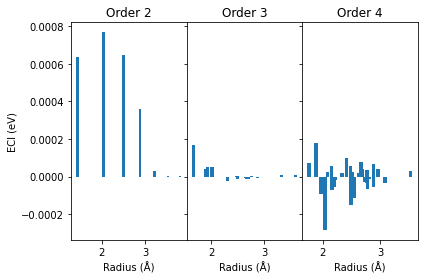

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, sharey=True)

for order, ax in enumerate(axes, start=2):
    df2 = df[df.order == order]  # pick out pairs/triplets/quadruplets
    ax.bar(df2.radius, df2.eci, width=0.06)
    ax.set_xlabel('Radius (Å)')
    ax.set_title(f'Order {order}')
    if order == 2:
        ax.set_ylabel('ECI (eV)')

plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
fig.align_ylabels(axes)

We can use this `ClusterExpansion` object to predict the energy of any structure as long as it is based on the lattice underlying the cluster space.

In [11]:
structure = prim.repeat((2, 2, 1))
structure.symbols = ['Au', 'Au', 'Pd', 'Pd']
ce.predict(structure)

-0.02481835955603695

We can also loop over the database of input structures and see how well our model does with respect to the data against which it has been fitted.
Here we organize these data in the form of a [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), which makes it easier to view, organize, and plot the data.

In [12]:
from pandas import DataFrame

data = []
for row in db.select():
    record = dict(concentration=row.concentration_Pd,
                  target=row.mixing_energy,
                  prediction=ce.predict(row.toatoms()))
    data.append(record)
df = DataFrame.from_dict(data)
df['error'] = df.prediction - df.target
rmse = np.sqrt(np.mean(df.error**2))
print(f'RMSE: {rmse:.3f} eV/atom')
df

RMSE: 0.000 eV/atom


,concentration,target,prediction,error
0,0.000000,0.000000,0.000001,1.456578e-06
1,1.000000,0.000000,-0.000005,-5.360160e-06
2,0.500000,-0.024819,-0.024818,2.965294e-07
3,0.500000,-0.019490,-0.019492,-2.024362e-06
4,0.333333,-0.021168,-0.021167,9.263756e-07
...,...,...,...,...
132,0.500000,-0.019570,-0.019570,-2.506406e-07
133,0.500000,-0.022390,-0.022390,6.129057e-08
134,0.666667,-0.017153,-0.017150,2.517462e-06
135,0.666667,-0.017129,-0.017129,-3.983460e-08


We can now plot the mixing energy (which is provide in units of eV/atom in the database) as a function of the Pd concentration.

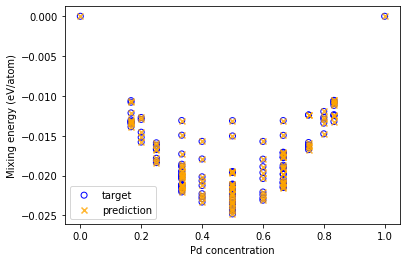

In [13]:
plt.scatter(df.concentration, df.target, marker='o', label='target', facecolors='none', edgecolors='b')
plt.scatter(df.concentration, df.prediction, marker='x', label='prediction', alpha=0.8, color='orange')
plt.xlabel('Pd concentration')
plt.ylabel('Mixing energy (eV/atom)')
plt.legend();

We can also generate a parity plot.

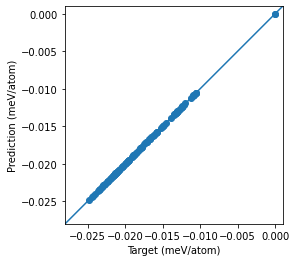

In [14]:
fig, ax = plt.subplots()
ax.scatter(df.target, df.prediction)
ax.plot([-1, 1], [-1, 1])
ax.set_xlim(-0.028, 0.001)
ax.set_ylim(-0.028, 0.001)
ax.set_xlabel('Target (meV/atom)')
ax.set_ylabel('Prediction (meV/atom)')
ax.set_aspect('equal')

We can also plot the error directly.

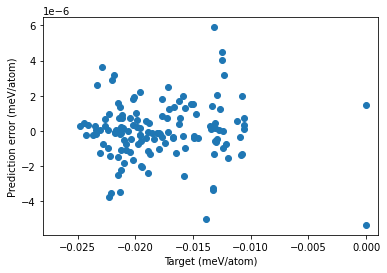

In [15]:
fig, ax = plt.subplots()
ax.scatter(df.target, df.prediction - df.target)
ax.set_xlim(-0.028, 0.001)
ax.set_xlabel('Target (meV/atom)')
ax.set_ylabel('Prediction error (meV/atom)');

In this case, the fit is extremely good, which is both because this is a very simple system, there is a lot of training data, and the number of parameters is relatively small.
To emulate these conditions we will now use a much smaller training data set.
Here, we use that the `get_fit_data` method of the `StructureContainer` object allows us to select structures by index.

RMSE: 0.006 eV/atom


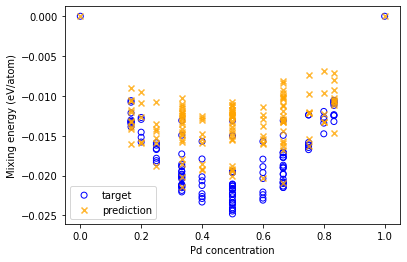

In [16]:
# construct CE using only 10 randomly selected structures
structure_indices = [0, 1, 3, 6, 9, 10, 15, 41, 60, 67]
X, E = sc.get_fit_data(structure_indices=structure_indices, key='mixing_energy')
J = np.dot(scipy.linalg.pinv(np.dot(X.T, X)), np.dot(X.T, E))
ce = ClusterExpansion(parameters=J, cluster_space=cs)

# compile results
data = []
for row in db.select():
    record = dict(concentration=row.concentration_Pd,
                  target=row.mixing_energy,
                  prediction=ce.predict(row.toatoms()))
    data.append(record)
df = DataFrame.from_dict(data)
df['error'] = df.prediction - df.target
rmse = np.sqrt(np.mean(df.error**2))
print(f'RMSE: {rmse:.3f} eV/atom')

# plot the results
plt.scatter(df.concentration, df.target, marker='o', label='target', facecolors='none', edgecolors='b')
plt.scatter(df.concentration, df.prediction, marker='x', label='prediction', alpha=0.8, color='orange')
plt.xlabel('Pd concentration')
plt.ylabel('Mixing energy (eV/atom)')
plt.legend();

The results are clearly much worse.
But we are not entirely lost.
We have physical insight with regard to the variation of the ECIs with cluster size (radius) and order.
The nature of the physical interactions dictates that interaction become weaker with increasing distance and the more bodies (atoms) are involved.
We can embed this knowledge via priors, which enables us to obtain physically meaningful models even in situations with very large spaces and/or limited reference data sets.
This approach is described in [Mueller and Ceder, Physical Review B **80**, 02410 (2009)](https://doi.org/10.1103/PhysRevB.80.024103) and also in the lecture notes.
In Project 2a you will use this approach yourself in order to construct cluster expansions.

## Some tips

### Writing and reading objects

The main `icet` objects can be written and read from disk.
This can be useful, e.g., for storing different cluster expansion models as demonstrated in the following cell.

In [17]:
ce.write('my-model.ce')
my_ce = ClusterExpansion.read('my-model.ce')

If you have read the `ClusterExpansion` object from disk and want to access the underlying cluster space, you get do so via the [`get_cluster_space_copy()` method](https://icet.materialsmodeling.org/moduleref_icet/cluster_expansion.html) of the `ClusterExpansion` object.

In [18]:
print(my_ce.get_cluster_space_copy())

====================================== Cluster Space ======================================
 space group                            : Fm-3m (225)
 chemical species                       : ['Au', 'Pd'] (sublattice A)
 cutoffs                                : 8.0000 7.0000 6.0000
 total number of parameters             : 64
 number of parameters by order          : 0= 1  1= 1  2= 7  3= 20  4= 35
 fractional_position_tolerance          : 2e-06
 position_tolerance                     : 1e-05
 symprec                                : 1e-05
-------------------------------------------------------------------------------------------
index | order |  radius  | multiplicity | orbit_index | multicomponent_vector | sublattices
-------------------------------------------------------------------------------------------
   0  |   0   |   0.0000 |        1     |      -1     |           .           |      .     
   1  |   1   |   0.0000 |        1     |       0     |          [0]          |      A     

### Scaling of cluster space with cutoff radii

It is instructive to consider how the number of orbits (distinct clusters) grows with the cutoff radii for each order.
First, using the helper function [`get_neighbor_shells`](https://hiphive.materialsmodeling.org/moduleref/utilities.html#hiphive.utilities.get_neighbor_shells) from the `hiphive` package, we find the neighbor shells of the structure (and thus suitable choices for cutoff parameters).

In [19]:
from hiphive.utilities import get_neighbor_shells

shells = get_neighbor_shells(prim, 8)

data = [dict(distance=sh.distance, count=sh.count) for sh in shells]
df = DataFrame.from_dict(data)
df

,distance,count
0,2.884996,12
1,4.080000,6
2,4.996959,24
3,5.769991,12
4,6.451046,24
5,7.066767,8
6,7.632981,48


Now we systematically create all cluster spaces with increasing cutoff radii and order.

In [20]:
possible_cutoffs = [sh.distance + 0.001 for sh in shells]  # we add a small number to avoid numerical ambiguity
data = []
for order in range(2, 5):
    for rc in possible_cutoffs:
        cutoffs = (order - 1) * [rc]
        cs = ClusterSpace(prim, cutoffs=cutoffs, chemical_symbols=['Au', 'Pd'])
        norbits = len([orb for orb in cs.orbit_data if orb['order'] == order])
        data.append(dict(order=order, rc=rc, norbits=norbits))
df = DataFrame.from_dict(data)

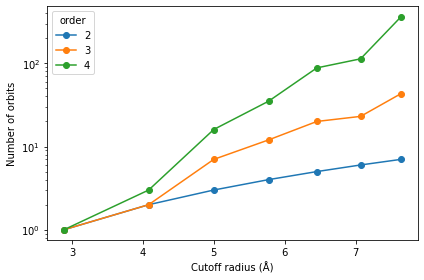

In [21]:
for order in range(df.order.min(), df.order.max() + 1):
    df2 = df[df.order == order]  # pick out pairs/triplets/quadruplets
    plt.semilogy(df2.rc, df2.norbits, 'o-', label=order)
plt.xlabel('Cutoff radius (Å)')
plt.ylabel('Number of orbits')
plt.legend(title='order')
plt.tight_layout()

The data illustrates the exponential increase in the number of orbits with order and cutoff radius.